# 2. Create test and train data

This template is used to check the robustness of the Sentiment Classification methods. First, 1000 tweets from the Twitter dataset are randomly combined, and must be analysed and classified as negative, neutral or positive. Then, several online datasets with pre-labeled tweets are imported and combined. This combined Dataset will serve as a training set. It is then checked whether the model using the trained set correclty labels the tweet sub-dataset. This will be evaluated against VADER and the extended VADER model, which will be constructed by manually observing patterns in the falsely classified tweets using the VADER method.

## 2.1. Load packages and data

This class loads all relevant packages and dates

### 2.1.1. Load packages

First, import all classes necessary for the running of this files. Then import the relevant classes from the Python `thesis_code` library. 

In [1]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords, wordnet # get stopwords from NLTK library & get all words in english language
from nltk.tokenize import word_tokenize # to create word tokens
from nltk.stem import WordNetLemmatizer # to reduce words to orginal form
from nltk import pos_tag # For Parts of Speech tagging
from nltk.tokenize import sent_tokenize

import string
import re

from sklearn.feature_extraction.text import CountVectorizer

# Label Encoding
from sklearn.preprocessing import LabelEncoder

# TF-IDF Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Model Building
from sklearn.naive_bayes import MultinomialNB

# Model Metrics
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score

import matplotlib.pyplot as plt
import os, sys
from datetime import datetime

# Vader sentiment classifier
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Load data that returns tweets
sys.path.insert(0, os.path.abspath('C:\\Users\\jdeboo\\PycharmProjects\\TwitterSentimentGARCH2021\\Code\\Sentiment analysis and aggregation'))
#from sentanalysis import TwitterSentimentAnalysis

# Surpress warnings
import warnings
warnings.filterwarnings("ignore")

### 2.1.2. Construct colors for plotting

Construct self-constructed colormap that will be used throughout this project

In [2]:
colors = ['seagreen', 'mediumaquamarine', 'steelblue', 'cornflowerblue', 'navy', 'black']

### 2.1.3. Load data

#### 2.1.3.1. Load data

In this section, load the data with company names. Also specify the storage location where the sentiment data must be stored.

In [3]:
# Specify location of data + file name and location of storage
data_loc = r'C:\Users\Jonas\Documents\Data'

# Specify location where daily sentiment scores must be stored
store_loc = r'C:\Users\Jonas\Documents\Data\Sentiment'

# Access company names DataFrame
file_name_comp = '\company_ticker_list_all.xlsx'
df_comp_names = pd.read_excel(data_loc + file_name_comp)

Create `df_train`, by concatenating labeled online DataFrames. Apply the same style to all DataFrames.

In [4]:
combined_dfs_loc = r'C:\Users\Jonas\OneDrive\Documenten'

# Read and adjust Apple tweets
apple_name = 'Apple-Twitter-Sentiment-DFE.csv'
df_apple = pd.read_csv(combined_dfs_loc + f'\\{apple_name}')
rename_dict_apple = {'1' : -1, '3': 0, '5': 1}
df_apple = df_apple.replace(to_replace=rename_dict_apple)

# Read and adjust airline tweets
airline_tweets = 'Tweets.csv'
df_airline = pd.read_csv(combined_dfs_loc + f'\\{airline_tweets}')
rename_dict_airline = {'negative' : -1, 'neutral': 0, 'positive': 1}
df_airline = df_airline.replace(to_replace=rename_dict_airline)
df_airline['sentiment'] = df_airline.airline_sentiment

# processed_tweets
neg = 'processedNegative.csv'
neu = 'processedNeutral.csv'
pos = 'processedPositive.csv'

df_neg = pd.read_csv(combined_dfs_loc + f'\\{neg}').T.reset_index()
df_neg['sentiment'] = -1
df_neu = pd.read_csv(combined_dfs_loc + f'\\{neu}').T.reset_index()
df_neu['sentiment'] = 0
df_pos = pd.read_csv(combined_dfs_loc + f'\\{pos}').T.reset_index()
df_pos['sentiment'] = 1

df_twitter = pd.concat([df_neg, df_neu, df_pos]).reset_index(drop=True)
df_twitter['text'] = df_twitter['index']

# Get Sentiment140 dataset
df_senti140 = pd.read_csv(combined_dfs_loc + f'\\sentiment140.csv', header=None)
rename_dict_senti140 = {0 : -1, 4: 1}
df_senti140 = df_senti140.replace(to_replace=rename_dict_senti140).sample(8000)
df_senti140[['sentiment', 'text']] = df_senti140[[0, 5]]

# Merge dfs
cols = ['text', 'sentiment']
df_train = pd.concat([df_apple[cols], df_twitter[cols], df_senti140[cols], df_airline[cols]]).reset_index(drop=True)
df_train.to_csv(store_loc + f'\\df_train.csv')

Create `df_test`, by extracting 1300 random tweets from all the Twitter datasets.

In [5]:
df_test = pd.read_csv(store_loc + f'\\df_test.csv')
df_test = df_test[df_test.sentiment.isin(['-1', '0', '1'])]

-----
-----

## 2.1. Create sentiment classification models

In this section several supervised classification algorithms are used in order to compare the performance based on the humanly annotated `df_test`, which is a sample of the tweets in our dataset on which we like to perform sentiment classification.

### 2.1.1. Supervised classification model

First, the supervised approach is used to classify the tweets. This is done using the Multinomial Naive Bayes Classifier.

Rebalance the training set and determine helper function used for preprocessing or Part-of-Speech tagging.

In [6]:
# Rebalance training dataset
df_train = df_train[df_train.sentiment != 'not_relevant']
smallest_sample = min(df_train['sentiment'].value_counts())
list_train = [df_train[df_train['sentiment'] == sent].sample(smallest_sample) for sent in df_train['sentiment'].unique()]
df_train = pd.DataFrame()
df_train = df_train.append([item for item in list_train])

def labelling(Rows):
    if(Rows['sentiment'] > 0):
        Label = 'positive'
    elif(Rows['sentiment'] < 0):
        Label = 'negative'
    else:
        Label = 'neutral'
    return Label

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Function to remove punctuations, links, emojis, and stop words
def preprocessTweets(tweet):
    tweet = tweet.lower()  #has to be in place
    text = []
    Lemmatizer = WordNetLemmatizer().lemmatize

    # Remove urls
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet)

    # Remove user @ references and '#' from tweet
    tweet = re.sub(r'\@\w+|\#|\d+', '', tweet)

    # Remove possible links
    tweet = re.sub('https?://\S+|www\.\S+', '', tweet)
    tweet = ''.join([t for t in tweet if t not in string.punctuation])   # remove all punctuations       
    tweet = ''.join([t for t in tweet if not t.isdigit()])   # remove all numeric digits   
    tweet = re.sub("[^a-zA-Z0-9]", " ", tweet)   # letters only 
    
    # Tokenize string
    tweet_tokens = word_tokenize(str(tweet))

    # Defining my NLTK stop words
    stop_words = list(stopwords.words('english'))
    word_list = ['aapl', 'apple', 'flight', 'airline', 'airtravel', 'airpassenger', 'delayed', 'gate', 'terminal']
    
    # Remove stopwords
    tweet_tokens = [w for w in tweet_tokens if w not in stop_words]
    tweet_tokens = [w for w in tweet_tokens if w not in word_list]

    # Assign Part-of-Speech to all words that are not stopwords
    word_pos = pos_tag(tweet_tokens)
        
    # Lemmatize all words
    lemm_words = [Lemmatizer(sw[0], get_wordnet_pos(sw[1])) for sw in word_pos]

    return(" ".join(lemm_words))

def important_features(vectorizer, classifier, n=10):
    class_labels = classifier.classes_
    feature_names = vectorizer.get_feature_names()

    topn_negative = sorted(zip(classifier.feature_count_[0], feature_names), reverse = True)[:n]
    topn_neutral = sorted(zip(classifier.feature_count_[1], feature_names), reverse = True)[:n]
    topn_positive = sorted(zip(classifier.feature_count_[2], feature_names), reverse = True)[:n]

    #print(classifier.feature_count_)
    
    print("-----------------------------------------")
    print("Important features in negative tweets")

    for coef, feat in topn_negative:
        print(class_labels[-1], coef, feat)

    print("-----------------------------------------")
    print("Important features in neutral tweets")

    for coef, feat in topn_neutral:
        print(class_labels[0], coef, feat)
        
    print("-----------------------------------------")
    print("Important features in positive tweets")

    for coef, feat in topn_positive:
        print(class_labels[1], coef, feat)

Preprocess training data, and encode target variables.

In [7]:
# Preprocess target and explanatory variales
df_train['sentiment'] = df_train.apply(labelling, axis = 1)
df_train['text'] = df_train['text'].apply(lambda tweet: preprocessTweets(tweet))

# Encode target variable
Encoder = LabelEncoder()
df_train["sentiment"] = Encoder.fit_transform(df_train["sentiment"])

# Defining our vectorizer with total words of 50000 and with uni to trigram model
TF_IDF = TfidfVectorizer(max_features = 20000, ngram_range = (1, 2))

# Fitting and transforming our reviews into a matrix of weighed words
X = TF_IDF.fit_transform(df_train['text'])

# Declaring our target variable
y = df_train["sentiment"]

# Instantiate model and fit 
Bayes = MultinomialNB(class_prior=[1/3, 1/3, 1/3])
model = Bayes.fit(X, y)

# Print the 20 most important features.
important_features(TF_IDF, model, n=20)

-----------------------------------------
Important features in negative tweets
2 125.50236385657716 get
2 118.95902706648235 unhappy
2 94.40688040378772 hour
2 84.94840924919373 im
2 84.1978303297284 go
2 75.77877736705715 time
2 72.68648919655422 cancel
2 69.56864835114335 miss
2 65.13204486786279 customer
2 63.80584266680995 cant
2 63.346674860297014 wait
2 62.53840757586958 dont
2 61.29427214818387 day
2 60.5280343617178 service
2 59.77561373472434 still
2 59.41288776969253 call
2 57.72955900081673 work
2 56.82424455143767 one
2 56.66285533185764 help
2 56.649692490944844 hold
-----------------------------------------
Important features in neutral tweets
0 114.48229699603766 rt
0 91.10735458411185 need
0 73.81783730036237 get
0 71.59438022585505 one
0 65.50155710557291 future
0 62.163428553614025 computer
0 61.166505665361655 outlet
0 61.11766950036986 ft
0 60.090601916455405 studio ft
0 60.090601916455405 outlet computer
0 60.090601916455405 one outlet
0 60.090601916455405 ft one


Test on subsample of actual Dataset

Unnormalized Confusion Matrix


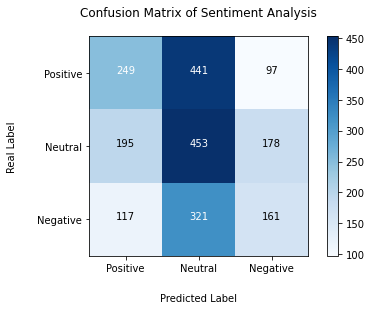

In [8]:
# Encode df_test labels.
df_test = pd.read_csv(store_loc + f'\\df_test.csv').fillna(1000)
df_test = df_test[df_test.sentiment != 1000]
df_test.sentiment[df_test.sentiment == '-'] = -1
df_test['sentiment'] = df_test.sentiment.astype(float)
df_test['sentiment'] = df_test.apply(labelling, axis=1)

# Get y_test and x_test
y_test = Encoder.transform(df_test.sentiment)
X_test = df_test.text

# Preprocess tweets using the preprocessTweets functionality and transform features using tf-idf vectorizer
X_test = X_test.apply(lambda tweet: preprocessTweets(tweet))
X_test = TF_IDF.transform(X_test)

# Predict target variables 
y_pred = model.predict(X_test)
df_test['Naive Bayes'] = Encoder.inverse_transform(y_pred)

# Create confusion matrix
ConfusionMatrix = confusion_matrix(y_test, y_pred)

# Plotting Function for Confusion Matrix
def plot_cm(cm, classes, title, normalized = False, cmap = plt.cm.Blues):

    plt.imshow(cm, interpolation = "nearest", cmap = cmap)
    plt.title(title, pad = 20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    if normalized:
        cm = cm.astype('float') / cm.sum(axis = 1)[: np.newaxis]
        cm = np.round(cm, 3)
        print("Normalized Confusion Matrix")
    else:
        print("Unnormalized Confusion Matrix")

    threshold = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], horizontalalignment = "center", color = "white" if cm[i, j] > threshold else "black")

    plt.tight_layout()
    plt.xlabel("Predicted Label", labelpad = 20)
plt.ylabel("Real Label", labelpad = 20)

plot_cm(ConfusionMatrix, classes = ["Positive", "Neutral", "Negative"], title = "Confusion Matrix of Sentiment Analysis")
plt.show()

### 2.1.2 Untrained VADER sentiment classification

Classification using VADER sentiment.

First, define preprocessingsteps voor VADER sentiment

In [9]:
def preprocessVader(tweet):   
    # Remove urls
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet)

    # Remove user @ references and '#' from tweet
    tweet = re.sub(r'\@\w+|\#|\d+', '', tweet)
    
    # Remove possible links
    tweet = re.sub('https?://\S+|www\.\S+', '', tweet)

    return(tweet)

Read test data to perform sentiment classification on.

In [10]:
# Instantiate VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

compounded_sentiment_series = []

for tweet in df_test.text:
    tweet = preprocessVader(tweet)
    
    # Perform sentiment analysis on seperate sentences within each tweet
    tokenized_tweets = sent_tokenize(tweet)

    compound_sentiment_tokenized_tweets = []
    for sentence in tokenized_tweets:
        compound_sentiment_tokenized_tweets += [analyzer.polarity_scores(sentence)['compound']]

    compounded_sentiment_series.append(np.mean(compound_sentiment_tokenized_tweets))

# Calculate the direction of the sentiment, if compounded sentiment > 0.05, direction is positive, if compounded
# sentiment < -.05 the direction is negative, otherwise the direction is neutral
senti_direction_series = []
for sentiment in compounded_sentiment_series:
    if sentiment > 0.05:
        senti_direction_series.append('positive')
    elif sentiment < -0.05:
        senti_direction_series.append('negative')
    else:
        senti_direction_series.append('neutral')
        
df_test['VADER'] = senti_direction_series

### 2.1.3 Trained VADER classification

Now train VADER to take into account domain of `df_test`. This is done by looking at misspecified tweets by simply using VADER. An feature importance analyzer is made to determine the most importance features in positive and negative tweets. These features are then added to the lexicon, if they are deemed appropriately functional.

In [11]:
# Define DataFrame with misspecified entries
df_wrong = df_test[df_test.sentiment != df_test.VADER]
df_wrong['text'] = df_wrong['text'].apply(lambda tweet: preprocessTweets(tweet))

# Defining our vectorizer with total words of 50000 and with uni to trigram model
TF_IDF = TfidfVectorizer(max_features = 1000, ngram_range = (1, 2))

# Fitting and transforming our reviews into a matrix of weighed words
X = TF_IDF.fit_transform(df_wrong['text'])

# Declaring our target variable
y = df_wrong["sentiment"]

# Instantiate model and fit 
Bayes = MultinomialNB()
model = Bayes.fit(X, y)

# Print the 20 most important features.
important_features(TF_IDF, model, n=40)

-----------------------------------------
Important features in negative tweets
positive 16.925734004657176 employee
positive 11.136146449955262 chevron
positive 10.698827974198698 climate
positive 10.612717095979763 company
positive 10.579370678113575 exxon
positive 9.696238180863485 amazon
positive 9.309784815403143 change
positive 8.947997153026058 climate change
positive 7.462093423317742 say
positive 7.072744921716007 mcdonalds
positive 6.533458136434471 pollution
positive 6.036481423473377 mobil
positive 6.036481423473377 exxon mobil
positive 5.992106702769672 oil
positive 5.7827220293959805 cocacola
positive 5.6119044768639395 like
positive 5.585661944528654 new
positive 5.560536077778849 walmart
positive 5.5190686524229005 work
positive 5.175298683097106 year
positive 5.093940042453105 policy
positive 5.02086561976752 via
positive 5.011956048072304 amp
positive 4.971481275742379 get
positive 4.958215476340496 right
positive 4.941776833167282 know
positive 4.936992814155675 resp

Using our intuition and the results presented above, try to extend the VADER lexicon to the specific domain of the test tweets, without 'overfitting' to the test set.

In [12]:
# Create dictionary of new words
new_words = {'sustainable': 1.5,
             'innovation': 1.5,
             'global warming': -1.5,
             'pollution': -1.5,
             'human': 1.5,
             'responsible': 1.5,
             'restore': 1.5,
             'environmental damage': -1.5,
             'layoff': -1.5,
             'un-green': -1.5,
             'ecofriendly': 1.5,
             'ESG': 1.5,
             'lawsuit': -1.5,
             'sued': -1.5,
             'allegation': -1.5,
             'discrimination': -1.5,
             'environmental': 1.5,
             'unequality': -1.5,
             'unequal': -1.5,
             'greenhouse gas': -1.5,
             'emmission': -1.5,
             'oil': -1.5,
             'favoritism': -1.5,
             'disrespectful': -1.5,
             'asocial': -1.5,
             'social': 1.5, 
             'trash': -1.5,
             'wasteful':-1.5,
             'garbage': -1.5,
             'plastic waste': -1.5, 
             'lose': -1.5,
             'abuse': -1.5,
             'impoverished': -1.5,
             'toxic': -1.5,
             'dumping': -1.5,
             'obesity': -1.5,
             'clean': 1.5,
             'cleanenergy': 1.5,
             'renewable': 1.5,
             'impact investing': 1.5,
             'CSR': 1.5,
             'human rights': 1.5,
             'recycling': 1.5,
             'renewables': 1.5,
             'green': 1.5,
             'ungreen': -1.5,
             'environmentally friendly': 1.5,
             'sexism': -1.5,
             'ethical': 1.5,
             'climate change': -1.5,
             'climatechange':-1.5,
             'climate disaster': -1.5,
             'climate disruption': -1.5,
             'polluting': -1.5,
             'harassment': -1.5,
             'unsafe': -1.5,
             'insecure': -1.5,
             
}

# Instantiate Sentiment Intensity Analyzer
analyzer = SentimentIntensityAnalyzer()

# Update lexicon
analyzer.lexicon.update(new_words)

compounded_sentiment_series = []

for tweet in df_test.text:
    tweet = preprocessVader(tweet)
    
    # Perform sentiment analysis on seperate sentences within each tweet
    tokenized_tweets = sent_tokenize(tweet)

    compound_sentiment_tokenized_tweets = []
    for sentence in tokenized_tweets:
        compound_sentiment_tokenized_tweets += [analyzer.polarity_scores(sentence)['compound']]

    compounded_sentiment_series.append(np.mean(compound_sentiment_tokenized_tweets))

# Calculate the direction of the sentiment, if compounded sentiment > 0.05, direction is positive, if compounded
# sentiment < -.05 the direction is negative, otherwise the direction is neutral
senti_direction_series = []
for sentiment in compounded_sentiment_series:
    if sentiment > 0.05:
        senti_direction_series.append('positive')
    elif sentiment < -0.05:
        senti_direction_series.append('negative')
    else:
        senti_direction_series.append('neutral')
        
df_test['adjusted VADER'] = senti_direction_series

------------------------------
------------------------------

## 2.2. Summary of results

Plot AUC in one plot.

In [39]:
n_pos = len(df_test[df_test.sentiment == 'positive'])
n_neg = len(df_test[df_test.sentiment == 'negative'])
n_neu = len(df_test[df_test.sentiment == 'neutral'])
n = len(df_test)

In [40]:
print(n_pos / n , n_neg / n, n_neu / n)

0.27079566003616634 0.35578661844484627 0.37341772151898733


Unnormalized Confusion Matrix


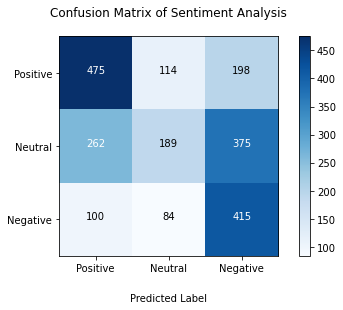

In [29]:
# Create confusion matrix
ConfusionMatrix = confusion_matrix(df_test.sentiment, df_test['adjusted VADER'])
plot_cm(ConfusionMatrix, classes = ["Positive", "Neutral", "Negative"], title = "Confusion Matrix of Sentiment Analysis")
plt.show()

0.37481578729570564 0.39014466546112114
0.46155039451386815 0.4706148282097649
0.47319960396193617 0.48779385171790235


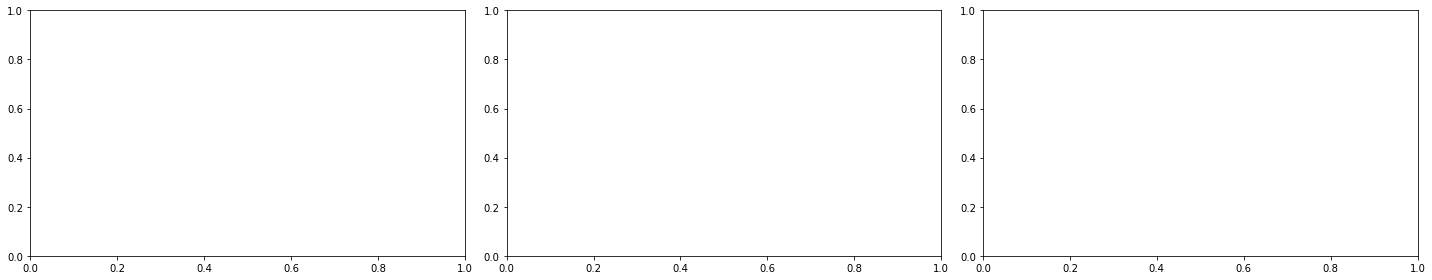

In [14]:
fig, axs = plt.subplots(figsize = (20,4), nrows = 1, ncols = 3)
cols = ['Naive Bayes', 'VADER', 'adjusted VADER']

for col, j in zip(cols, range(len(axs))):    
    #df_test['correct'] = [int(df_test['sentiment'][i] == df_test[col][i]) for i in range(len(df_test['sentiment']))]
    #df_test['false'] = [int(df_test['sentiment'][i] != df_test[col][i]) for i in range(len(df_test['sentiment']))]

    # Plot AUC
    #axs[j].plot(df_test.false.cumsum() / np.sum(df_test.false), df_test.correct.cumsum() / np.sum(df_test.correct), c='black')
    #axs[j].plot([0,1], [0,1], linestyle='--', c='gray')
    f1 = f1_score(df_test['sentiment'], df_test[col], average='macro')
    accuracy = accuracy_score(df_test['sentiment'], df_test[col])
    print(f1, accuracy)
    #axs[j].set_title(f'Accuracy plot of sentiment classification approach with {col}' + '\n' + f'Accuracy: {accuracy}')

plt.tight_layout()

# Store figures as PNG
#fig.savefig(os.path.join(store_loc, f'robustness sentiment analysis.png'))


-----
-----